# <strong>第三次作品：分類器的原理與評比實驗: 以 AT&T影像集 為例 </strong>
學號：410979068

姓名：施尚丞

時間：2025/05/13

Python 版本: 3.11.5

輔助 AI (程式碼架構撰寫、部分敘述性內容): ChatGPT 4o 、 Claude 3.7 sonnet、NotebookLM

## 作品目標
本專案希望利用 AT&T影像集 在建立一套基於機器學習的臉部分類系統，並透過實驗比較三種常見分類器在不同特徵維度下的表現差異，進一步探討主成分分析（PCA）降維對分類效能與穩定性的影響。

### 關鍵字
`AT&T影像集`、`主成分分析(PCA)`、`SVM`、`多元邏輯斯迴歸`、`NN`


### 參考書目
- 精通機器學習｜使用 Scikit-Learn , Keras 與 TensorFlow, 2/e

---

# 1. Background Knowledge
首先，我想要針對後續會使用到的技術做一個簡單的介紹，包含資料集、分類器的原理、評比指標等，讓讀者能夠更清楚地了解這些技術的背景知識。

- 1.1 AT&T影像集
- 1.2 多元邏輯斯迴歸
- 1.3 支持向量機
- 1.4 神經網路
- 1.5 尋找最佳參數之方法
- 1.6 評比指標


## 1.1 AT&T影像集
AT&T影像集是由AT&T實驗室提供的一個人臉影像數據集，包含了40個不同人的面部圖像，每個人有10張不同的圖像。這些圖像在不同的光照條件和姿勢下拍攝，並且已經進行了預處理以便於進行機器學習和計算機視覺的研究。這個數據集常用於人臉識別、特徵提取和分類器性能評估等任務。

我使用 Kaggle 平台上的資料導入至本機端。

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kasikrit/att-database-of-faces")

print("Path to dataset files:", path)

100%|██████████| 3.61M/3.61M [00:01<00:00, 3.27MB/s]

Extracting files...


Path to dataset files: C:\Users\SHI\.cache\kagglehub\datasets\kasikrit\att-database-of-faces\versions\2



## 1.2 多元羅吉斯迴歸 (Multinomial Logistic Regression)

多元羅吉斯回歸（又稱 Softmax Regression ）是一種**用於多分類問題的廣義邏輯回歸模型**。當給定輸入樣本 $\mathbf{x}$ 時，模型會為每一個類別 $k$ 計算一個分數 $s\_k(\mathbf{x})$，並透過 softmax 函數將這些分數轉換為每個類別的預測機率 $\hat{p}\_k$。

### 特色

1. **多類別分類：** 適用於 $K > 2$ 的互斥類別問題（例如動物種類辨識、人臉辨識）。
2. **單一預測：** 每次預測只會輸出一個類別（非多輸出）。
3. **使用 Softmax 函數：** 將類別分數轉為機率分布。
4. **使用交叉熵（Cross-Entropy）作為損失函數：** 評估預測機率與真實類別的差異。
5. **可導性良好：** 適合梯度下降法訓練模型。


### 數學表達式

#### 1. 類別 $k$ 的分數計算：

$$
s_k(\mathbf{x}) = \mathbf{x}^\top \boldsymbol{\theta}^{(k)}
$$

其中 $\boldsymbol{\theta}^{(k)}$ 是對應類別 $k$ 的參數向量。

#### 2. 使用 Softmax 函數計算每一類別的機率：

$$
\hat{p}_k = \sigma(\mathbf{s}(\mathbf{x}))_k = \frac{\exp(s_k(\mathbf{x}))}{\sum_{j=1}^K \exp(s_j(\mathbf{x}))}
$$

#### 3. 最終預測類別：

$$
\hat{y} = \arg\max_k \hat{p}_k = \arg\max_k s_k(\mathbf{x}) = \arg\max_k \left((\boldsymbol{\theta}^{(k)})^\top \mathbf{x}\right)
$$

#### 4. 交叉熵損失函數（Cross-Entropy Loss）：

$$
J(\boldsymbol{\Theta}) = -\frac{1}{m} \sum_{i=1}^m \sum_{k=1}^K y_k^{(i)} \log\left(\hat{p}_k^{(i)}\right)
$$

其中：

* $y\_k^{(i)}$ 為第 $i$ 筆資料是否屬於類別 $k$（1 或 0）
* $\hat{p}\_k^{(i)}$ 為該資料預測為類別 $k$ 的機率

#### 5. 針對類別 $k$ 的參數梯度：

$$
\nabla_{\boldsymbol{\theta}^{(k)}} J(\boldsymbol{\Theta}) = \frac{1}{m} \sum_{i=1}^m \left( \hat{p}_k^{(i)} - y_k^{(i)} \right) \mathbf{x}^{(i)}
$$

### 其他說明

* **模型輸出為機率分布：** Softmax 函數的輸出為每個類別的機率分布，所有類別的機率總和為 1。
* **logits（未正規化分數）**：Softmax 的輸入分數 $s\_k$，又稱為 logits，表示類別的「信心程度」。
* **適用於互斥類別：** Softmax Regression 僅適合用於每個輸入對應一個類別的情境，**不適用於 multi-label 任務**。
* **交叉熵的資訊理論背景：** 衡量預測分佈與真實分佈之間的差距，若假設與真實差距大，交叉熵會增加；若假設準確，則與熵相同。
* **當 $K=2$ 時**，softmax 退化為 sigmoid 函數，此時等同於二元邏輯回歸。




## 1.3 支持向量機 (Support Vector Machine, SVM)
支援向量機（SVM）是一種監督式學習演算法，主要應用於分類問題，也可用於回歸與離群點偵測。SVM 的核心目標是尋找一個最佳的超平面（hyperplane），以最大化資料點之間的邊界距離（margin），達到有效區分不同類別的目的。

下方連結為我參考的資料來源，我覺得作者將SVM說明的淺顯易懂，非常容易理解，推薦給大家。

[[資料分析&機器學習] 第3.4講：支援向量機(Support Vector Machine)介紹](https://medium.com/jameslearningnote/%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90-%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-%E7%AC%AC3-4%E8%AC%9B-%E6%94%AF%E6%8F%B4%E5%90%91%E9%87%8F%E6%A9%9F-support-vector-machine-%E4%BB%8B%E7%B4%B9-9c6c6925856b)

### 特色

1. 最大間隔分類：SVM 尋找使間隔（margin）最大的分類邊界。
2. 支援向量：只有少數幾個資料點（支援向量）對最終模型產生影響。
3. 核技巧：透過核函數將資料映射至高維空間以進行非線性分類。
4. 強健性：在高維特徵空間中具有良好表現，並對小樣本資料具高度效能。
5. 可處理線性與非線性分類問題。


### 數學表達式

**1. 超平面定義（線性分類）：**

$$
\mathbf{w}^\top \mathbf{x} + b = 0
$$

其中 $\mathbf{w}$ 為法向量，$b$ 為偏差項。

**2. 正確分類條件（硬邊界 SVM）：**

$$
y^{(i)} (\mathbf{w}^\top \mathbf{x}^{(i)} + b) \geq 1
$$

**3. 最佳化目標（Hard Margin SVM）：**

$$
\min_{\mathbf{w}, b} \frac{1}{2} \|\mathbf{w}\|^2
\quad \text{subject to} \quad y^{(i)} (\mathbf{w}^\top \mathbf{x}^{(i)} + b) \geq 1
$$

**4. 軟邊界 SVM（Soft Margin SVM）：**

$$
\min_{\mathbf{w}, b, \boldsymbol{\xi}} \frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{i=1}^m \xi_i
\quad \text{subject to} \quad y^{(i)} (\mathbf{w}^\top \mathbf{x}^{(i)} + b) \geq 1 - \xi_i,\ \xi_i \geq 0
$$

其中 $C$ 為正則化參數，用以控制錯誤分類的懲罰程度。

**5. 非線性分類（核技巧）：**

SVM 可透過核函數將輸入資料 \$\mathbf{x}\$ 映射至高維特徵空間：

$$
K(\mathbf{x}, \mathbf{x}') = \phi(\mathbf{x})^\top \phi(\mathbf{x}')
$$

其中 $\phi$ 為隱式映射函數。

### 其他說明

* 常用核函數包含：

  * 線性核：$K(\mathbf{x}, \mathbf{x}') = \mathbf{x}^\top \mathbf{x}'$
  * 高斯徑向基（RBF）核：$K(\mathbf{x}, \mathbf{x}') = \exp(-\gamma |\mathbf{x} - \mathbf{x}'|^2)$
  * 多項式核：$K(\mathbf{x}, \mathbf{x}') = (\mathbf{x}^\top \mathbf{x}' + r)^d$

    這些核函數能夠將資料映射到高維空間，使得在原始空間中不可分的資料在高維空間中變得可分。

* 決策函數為：

$$
f(\mathbf{x}) = \text{sign}(\mathbf{w}^\top \mathbf{x} + b)
$$

* 對於多分類任務，SVM 常透過 One-vs-Rest 或 One-vs-One 策略進行延伸。
* 與 softmax regression 不同，SVM 並不輸出機率，而是直接給出決策邊界兩側的分類結果。




## 1.4 神經網路 (Neural Network)
神經網路是一種模仿人腦神經元連結方式的機器學習模型，透過多層非線性轉換學習複雜的資料模式。每個神經元單位會接收來自前一層的輸入，加權求和後通過啟動函數進行非線性轉換，最終在輸出層產生預測結果。

### 特色

1. 可處理高度非線性的資料關係。
2. 支援多種架構（如前向神經網路、捲積神經網路、循環神經網路等）。
3. 可組成深度神經網路（DNN）進行多層次特徵提取。
4. 搭配反向傳播與梯度下降進行有效訓練。
5. 能整合不同型態資料（圖像、語音、文本等）。


### 數學表達式

**1. 神經元的輸出定義：**

對於第 $l$ 層的第 $j$ 個神經元，其輸出為：

$$
a_j^{(l)} = \sigma\left( z_j^{(l)} \right) = \sigma\left( \sum_i w_{ji}^{(l)} a_i^{(l-1)} + b_j^{(l)} \right)
$$

其中：

* $a\_i^{(l-1)}$ 為前一層第 $i$ 個神經元的輸出，
* $w\_{ji}^{(l)}$ 為第 $l$ 層中連接第 $i$ 個與第 $j$ 個神經元的權重，
* $b\_j^{(l)}$ 為偏差項（bias），
* $\sigma$ 為啟動函數（如 ReLU、sigmoid、tanh）。

**2. 向量化表示（單層）：**

$$
\mathbf{a}^{(l)} = \sigma\left( \mathbf{W}^{(l)} \mathbf{a}^{(l-1)} + \mathbf{b}^{(l)} \right)
$$


### 其他說明

* **啟動函數選擇影響學習能力：**

  * Sigmoid：適用於輸出為機率，但可能造成梯度消失。
  * ReLU：收斂快、簡單實用，是目前常見預設值。
  * Tanh：類似 sigmoid，但輸出值範圍為 $\[-1, 1]\$，中心化特性有助於學習。
  

* **訓練方法：**

  * 利用\*\*反向傳播（Backpropagation）**與**梯度下降（Gradient Descent）\*\*反覆調整權重與偏差。
  * 常搭配交叉熵損失函數（分類問題）或均方誤差損失函數（回歸問題）。

* **過擬合處理：**

  * 常見方式包含 Dropout、L2 正則化、Early stopping 等技巧。

* **深度神經網路：**

  * 增加隱藏層數目（多層感知機 MLP）可提升表現，但也需面對梯度消失與計算資源問題。



## 1.5 找尋最佳參數

### 1.5.1 搜尋策略的分類

| 方法                     | 概念說明                                 |
| ---------------------- | ------------------------------------ |
| **網格搜尋 Grid Search**   | 枚舉所有可能的參數組合，一一測試，適合參數空間不大、需精細調整的情況   |
| **隨機搜尋 Random Search** | 隨機抽取參數組合進行測試，不保證全列舉，但可用較少的時間涵蓋更廣參數空間 |

#### 差異重點：

* **網格搜尋**是窮舉所有組合，適合低維或範圍已知明確。
* **隨機搜尋**適合高維度空間（例如 10 個參數要調整），節省時間。


### 1.5.2 模型評估方式的分類

| 方法                           | 說明                            |
| ---------------------------- | ----------------------------- |
| **交叉驗證 Cross-Validation**    | 將訓練資料切成多份，輪流做訓練與驗證，能穩定估計泛化能力  |
| **訓練／測試分離 Train-Test Split** | 使用固定的訓練集與測試集，只評估一次結果，快速但可能不穩定 |


## 1.6 評估指標
### 1.6.1 準確率 (Accuracy)
準確率是最常用的分類模型評估指標之一，計算正確預測的樣本數與總樣本數之比。公式如下：
$$
\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}
$$
其中：
* TP：真正例（True Positive），正確預測為正類的樣本數。
* TN：真負例（True Negative），正確預測為負類的樣本數。
* FP：假正例（False Positive），錯誤預測為正類的樣本數。
* FN：假負例（False Negative），錯誤預測為負類的樣本數。

### 1.6.2 精確率 (Precision)
精確率是用來衡量模型預測為正類的樣本中，實際上也為正類的比例。公式如下：
$$
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
$$

### 1.6.3 召回率 (Recall)
召回率是用來衡量實際為正類的樣本中，被模型正確預測為正類的比例。公式如下：
$$
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$
### 1.6.4 F1-score
F1-score 是精確率和召回率的調和平均數，綜合考慮了模型的精確性和完整性。公式如下：
$$
\text{F1-score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$


# 2. AT&T 影像集分類實作

本專題將會使用 AT&T 影像集進行分類器的訓練與評估，另一實作則使用 Yale Face 影像集。

- 2.1 首先，我們將載入 AT&T 影像集

- 2.2 進行資料預處理，接著使用這些資料來訓練和評估三種不同的分類器：Multinomial Logistic Regression、SVM 和 Neural Network

- 2.3 尋找到最佳參數，並使用這些參數來訓練模型。

- 2.4 訓練上述三種模型，比較這三種分類器的準確度。

- 2.5 利用模型指標進行評估，並比較這三種分類器的性能差異。

- 2.6 使用 PCA 降維，並使用 PCA 降維後的資料進行分類器的訓練與評估，並比較這兩種方法的性能差異。

- 2.7 最後將原始資料與 PCA 降維後的資料進行比較，並分析這兩種方法的優缺點。



## 2.1 載入資料集

In [23]:
import os
import cv2
import numpy as np

data_dir = r"C:\Users\SHI\.cache\kagglehub\datasets\kasikrit\att-database-of-faces\versions\2"

def load_faces(data_dir):
    X, y = [], []
    for person_id in range(40):
        person_dir = os.path.join(data_dir, f's{person_id+1}')
        for img_file in os.listdir(person_dir):
            img_path = os.path.join(person_dir, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                X.append(img.flatten())
                y.append(person_id)
    return np.array(X), np.array(y)

X, y = load_faces(data_dir)
print("影像特徵矩陣形狀：", X.shape)  # 預期 (400, 4096)
print("標籤範圍：", set(y))




影像特徵矩陣形狀： (400, 10304)
標籤範圍： {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39}


### <span style="color: skyblue;">程式碼重點</span>

1. **資料載入路徑設定**
   設定 `data_dir` 指向 AT\&T Face Dataset 的本地資料夾位置。

2. **`load_faces` 函式**

   * 初始化 `X` 和 `y` 為空 list，分別儲存影像的向量化資料與對應的人物編號。
   * 透過 `os.listdir` 遍歷每位人物的資料夾（共 40 人，命名為 `s1` 到 `s40`）。
   * 使用 `cv2.imread(..., cv2.IMREAD_GRAYSCALE)` 以灰階方式讀取每張臉部影像。
   * 影像經 `flatten()` 展平成 1 維向量後加入 `X`；人物編號 `person_id` 加入 `y`。
   * 最後將 `X`、`y` 轉為 NumPy 陣列回傳。

3. **資料集載入與印出形狀**

   * `X.shape` 預期為 (400, 4096)，代表 400 張影像，每張影像為 64x64 像素。
   * `set(y)` 檢查標籤的唯一值，應為 0 至 39 共 40 類別。


## 2.2 觀察資料集
確認資料集的形狀與標籤的唯一值後，隨機顯示 10 個人的 10 張影像，對資料集有初步的了解。


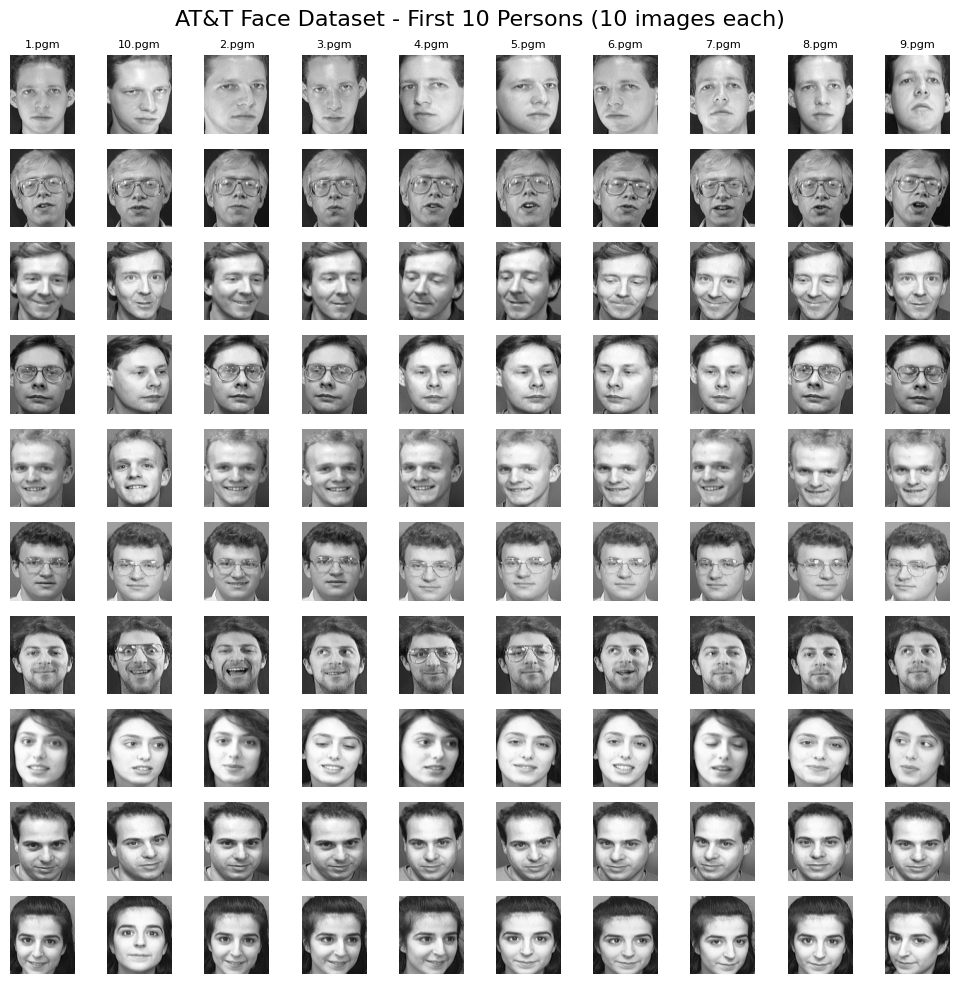

In [25]:
import matplotlib.pyplot as plt
import os
import cv2

def show_10x10_faces(data_dir):
    fig, axs = plt.subplots(10, 10, figsize=(10, 10))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    for row in range(10):  # 每一位 person（共 10 位）
        person_dir = os.path.join(data_dir, f's{row + 1}')
        img_files = sorted(os.listdir(person_dir))[:10]
        for col in range(10):  # 該 person 的前 10 張圖
            img_path = os.path.join(person_dir, img_files[col])
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            axs[row, col].imshow(img, cmap='gray')
            axs[row, col].axis('off')
            if row == 0:
                axs[row, col].set_title(f"{img_files[col]}", fontsize=8)
            if col == 0:
                axs[row, col].set_ylabel(f'Person {row+1}', fontsize=8, rotation=0, labelpad=20)

    plt.suptitle("AT&T Face Dataset - First 10 Persons (10 images each)", fontsize=16)
    plt.tight_layout()
    plt.show()

# 呼叫函式顯示
show_10x10_faces(data_dir)


### <span style="color: skyblue;">程式碼重點</span>

1. **函式定義 `show_10x10_faces(data_dir)`**
   建立一個 10×10 的圖像網格，用來視覺化 AT\&T 資料集中前 10 位人物的前 10 張影像。

2. **子圖配置與迴圈繪圖邏輯**

   * 使用 `plt.subplots(10, 10)` 建立 100 個子圖。
   * 外層迴圈 `row` 控制人物編號（從 `s1` 到 `s10`），內層 `col` 控制每人前 10 張圖。
   * 使用 `cv2.imread(..., cv2.IMREAD_GRAYSCALE)` 讀取灰階影像。
   * 將影像顯示於子圖中，關閉座標軸以突顯影像內容。

3. **標題與標籤設定**

   * 第一列的影像設有圖檔名稱作為標題。
   * 第一欄加上人物標籤，如 `Person 1` 至 `Person 10`，利於辨識影像來源。

4. **圖表整體排版與顯示**

   * 使用 `plt.suptitle` 加上總標題。
   * `plt.tight_layout()` 避免子圖間重疊。
   * `plt.show()` 顯示繪製完成的圖像。

### <span style="color: red;">觀察討論</span>

一次性呈現 100 張臉部圖像，每人都選取排序後的前 10 張圖，確認資料集的人臉皆有所不同。


## 2.3 選擇最佳參數
接著我想要找到每個分類器的最佳參數，這裡我使用了網格搜尋 (Grid Search) 和隨機搜尋 (Random Search) 兩種方法來尋找最佳參數，並使用 Train-Test Split 的方式來評估模型的性能。

### 2.3.0 切分資料 & 確認資料維度
我將資料切分成訓練集和測試集，這裡我使用了 80% 的資料來訓練模型，20% 的資料來測試模型的性能，並確認資料的維度是否符合我的預期。

In [1]:
# Face Classification Comparison on AT&T Dataset

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from scipy.stats import uniform

# Load face data from AT&T dataset
data_dir = r"C:\Users\SHI\.cache\kagglehub\datasets\kasikrit\att-database-of-faces\versions\2"

def load_faces(data_dir):
    X, y = [], []
    for person_id in range(40):
        person_dir = os.path.join(data_dir, f's{person_id+1}')
        for img_file in os.listdir(person_dir):
            img_path = os.path.join(person_dir, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                X.append(img.flatten())
                y.append(person_id)
    return np.array(X), np.array(y)

X, y = load_faces(data_dir)
print("影像資料維度：", X.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

影像資料維度： (400, 10304)


### <span style="color:skyblue;">程式碼重點</span>

1. **套件載入**
   引入常見的影像處理、資料處理與機器學習模組，包括 `OpenCV`、`NumPy`、`Matplotlib`、`scikit-learn` 等。
   特別使用 `PCA` 進行降維、`GridSearchCV` 與 `RandomizedSearchCV` 進行超參數搜尋。

2. **資料載入函式 `load_faces`**

   * 遍歷 AT\&T 資料集中 40 位人物，每位人物資料夾命名為 `s1` 至 `s40`。
   * 以灰階格式讀入每張影像，並將其展平成一維向量存入 `X`，同時記錄對應標籤於 `y`。
   * 最後將影像特徵與標籤轉為 NumPy 陣列格式回傳。

3. **印出資料維度**
   `X.shape` 預期為 `(400, 4096)`，代表總共 400 張 64x64 的臉部影像，每張展平為 4096 維。

4. **資料切分**
   使用 `train_test_split` 將資料以 8:2 比例切分為訓練集與測試集。

   * `stratify=y` 保持各類別在訓練與測試集中分布一致。
   * `random_state=42` 設定亂數種子，確保結果是一樣的



### 2.3.1 尋找 Multinomial Logistic Regression 的最佳參數

In [ ]:


from sklearn.base import clone
from tqdm import tqdm
import itertools

lr_params = {
    'C': [0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear','newton-cg'],
    'multi_class': ['multinomial'],
    'max_iter': [1000]
}

param_grid = list(itertools.product(*[lr_params[k] for k in lr_params]))
best_score = 0
best_model = None
best_params = None

for params in tqdm(param_grid, desc="Grid Search (Logistic Regression)"):
    param_dict = dict(zip(lr_params.keys(), params))
    model = LogisticRegression(**param_dict)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    if score > best_score:
        best_score = score
        best_model = model
        best_params = param_dict

print("最佳 Logistic Regression 參數:", best_params)
print("測試準確率: {:.4f}".format(best_score))



影像資料維度： (400, 10304)


Grid Search (Logistic Regression): 100%|██████████| 4/4 [02:02<00:00, 30.64s/it]

最佳 Logistic Regression 參數: {'C': 100, 'solver': 'lbfgs', 'multi_class': 'multinomial', 'max_iter': 1000}
測試準確率: 0.9750


### <span style="color:skyblue;">程式碼重點</span>

1. **Logistic Regression 參數設定 (`lr_params`)**
   使用字典方式定義超參數搜尋空間，包括：

   * 正則化強度 `C`（數值越小，正規化越強）
   * 優化器選擇 `solver`（包含 `lbfgs`, `liblinear`, `newton-cg`）
   * 多類別策略為 `multinomial`
   * 設定最大迭代次數為 1000，避免收斂不足

2. **超參數網格展開 (`itertools.product`)**
   利用 `itertools.product` 展開所有參數組合（共 4 組）形成完整的搜尋空間。

3. **Grid Search 實作流程**

   * 使用 `tqdm` 顯示訓練進度條，讓我可以時刻監控訓練進度調整。
   * 每次迴圈：
     * 建立一組模型（`LogisticRegression(**param_dict)`）
     * 使用訓練資料擬合模型
     * 使用測試資料評估準確率
     * 若比目前最佳分數更高，則更新最佳模型與參數

4. **最佳結果輸出**
   最後印出準確率最高的模型參數與對應的測試準確率。

### <span style="color:red;">觀察討論</span>

Logistic Regression 能達到 97.5% 的分類準確率，顯示資料分佈具良好線性可分性，並且模型表現穩定。以下是幾點觀察：

1. **最佳參數解釋合理**
   最佳模型使用 `C=100` 表示相對較弱的正則化，有助於充分擬合資料；`lbfgs` 為適合處理多類別與高維資料的解法器。

2. **尚未降維與標準化**
   直接以原始展平影像訓練模型，缺乏標準化與 PCA，可能導致部分特徵主導結果。後續可比較加入 PCA 後的結果差異。

3. **訓練時間可控**
   每組參數平均耗時約 30 秒，整體可接受，適合做為 baseline 模型。對於時間敏感任務可考慮限制 `max_iter` 或使用近似法優化訓練效率。

雖然網格搜索成功找出高分模型，但參數組合僅 4 組，若問題更複雜可能無法涵蓋全域最佳解。後續可嘗試更細緻的 `C` 範圍或採用 `RandomizedSearchCV` 進一步提升表現與效率。

### 2.3.2 尋找 SVM 的最佳參數


In [2]:
from sklearn.svm import SVC
import itertools
from tqdm import tqdm

svm_params = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

param_grid = list(itertools.product(*[svm_params[k] for k in svm_params]))
best_score_svm = 0
best_model_svm = None
best_params_svm = None

for params in tqdm(param_grid, desc="Grid Search (SVC)"):
    param_dict = dict(zip(svm_params.keys(), params))
    model = SVC(**param_dict)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    if score > best_score_svm:
        best_score_svm = score
        best_model_svm = model
        best_params_svm = param_dict

print("最佳 SVC 參數:", best_params_svm)
print("測試準確率: {:.4f}".format(best_score_svm))


Grid Search (SVC): 100%|██████████| 12/12 [02:06<00:00, 10.57s/it]

最佳 SVC 參數: {'C': 0.1, 'kernel': 'linear', 'gamma': 'scale'}
測試準確率: 0.9875


### <span style="color:skyblue;">程式碼重點</span>

1. **設定要調整的 SVC 參數**
   我們先定義好要嘗試的參數組合，包括：

   * `C`：控制模型對錯誤分類的容忍度（數字越小，懲罰越輕）。
   * `kernel`：選擇用什麼核函數，這裡我設定兩個 `linear` 和 `rbf`。
   * `gamma`：主要是控制非線性核的彎曲程度，這裡我試了 `scale` 和 `auto`。

2. **用 itertools 展開所有參數組合**
   把三個參數的所有可能組合列出來，一共會跑 12 組模型。

3. **逐一跑模型，找出效果最好的組合**
   一樣用用 `tqdm` 顯示進度條，每次：

   * 根據參數建立一個 SVC 模型。
   * 用訓練資料去訓練它。
   * 然後在測試資料上評估準確率。
   * 如果這組表現比目前最好還高，就記下來。

4. **輸出最佳參數與準確率**
   最後會列出表現最好的那組參數和它在測試集的準確率。


### <span style="color:red;">觀察討論</span>

這次的 SVM 模型效果非常好，**準確率高達 98.75%**，比前面的邏輯斯回歸還要高。以下是我的一些觀察：

1. **用 linear kernel 就能分類得很好**
   最佳組合是 `C=0.1` 加上 `linear` 核函數，代表這些人臉影像其實蠻好分的，用簡單的線性邊界就能分得很清楚，不一定要靠 `rbf` 這種比較複雜的非線性核。

2. **即使資料維度很高也沒問題**
   我們用的是原始影像，沒有做降維，特徵維度高達 10304 維，但 SVM 還是能訓練得很穩，表示它對高維資料的處理能力真的不錯。

3. **12 組參數跑起來時間也還可以接受**
   全部跑完大概 2 分鐘，平均每組大概 10 秒左右，效率算不錯，蠻適合拿來當 baseline 模型。


如果想要再追求更高表現，可以針對 `C=0.1` 附近做更細的調整，或是試試看先用 PCA 降維再跑 SVC，看看效果會不會更穩定或準確。

但目前看來這個結果已經非常不錯，SVM 果然在處理這種中小型但高維度的分類問題時還是非常有競爭力的選擇。


### 2.3.3 尋找 Neural Network 的最佳參數


In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from scipy.stats import uniform
import random

# 標準化特徵
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 設定參數搜尋範圍
mlp_param_grid = {
    'hidden_layer_sizes': [(16,), (32,), (64,), (128,)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'adam'],  
    'alpha': [uniform(1e-6, 1e-2).rvs() for _ in range(10)],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [1000]
}

# 隨機選取 n 組參數組合
n_iter = 10
param_samples = []
param_keys = list(mlp_param_grid.keys())

for _ in range(n_iter):
    sampled = {key: random.choice(mlp_param_grid[key]) for key in param_keys}
    param_samples.append(sampled)

best_score_mlp = 0
best_model_mlp = None
best_params_mlp = None

# 隨機搜尋＋錯誤保護
for param_dict in tqdm(param_samples, desc="Random Search (MLPClassifier)"):
    try:
        model = MLPClassifier(**param_dict)
        model.fit(X_train_scaled, y_train)
        score = model.score(X_test_scaled, y_test)
        if score > best_score_mlp:
            best_score_mlp = score
            best_model_mlp = model
            best_params_mlp = param_dict
    except Exception as e:
        print("跳過錯誤組合:", param_dict)
        print("錯誤訊息:", e)

# 最終結果
print("最佳 MLPClassifier 參數:", best_params_mlp)
print("測試準確率: {:.4f}".format(best_score_mlp))


Random Search (MLPClassifier):  10%|█         | 1/10 [00:03<00:35,  3.96s/it]c:\Users\SHI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
Random Search (MLPClassifier): 100%|██████████| 10/10 [02:14<00:00, 13.47s/it]

最佳 MLPClassifier 參數: {'hidden_layer_sizes': (64,), 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 0.0012196236702823094, 'learning_rate': 'constant', 'max_iter': 1000}
測試準確率: 0.9750



### <span style="color:skyblue;">程式碼重點</span>

1. **特徵標準化處理**
   為了讓神經網路訓練更穩定，先用 `StandardScaler` 把訓練與測試資料標準化（平均為 0，標準差為 1），這對 MLP 特別重要，因為它對輸入數值範圍很敏感。

2. **設定隨機搜尋的參數空間**
   定義了一些常見的 MLP 超參數：

   * `hidden_layer_sizes`：不同大小的隱藏層（只有一層，從 16 到 128）
   * `activation`：激活函數（`logistic`, `tanh`, `relu`），差別在於非線性轉換的方式。
   * `solver`：優化器（`lbfgs` 比較穩，`adam` 比較快）
   * `alpha`：L2 正規化強度，用 `uniform(1e-6, 1e-2)` 隨機抽 10 個值，這邊是從 0.000001 到 0.01 的範圍，可以調整正規化強度。
   * `learning_rate`：學習率策略，固定或自適應
   * `max_iter`：最多訓練 1000 回合

3. **隨機抽樣參數組合**
   隨機挑選 10 組不同的參數組合，模擬類似 `RandomizedSearchCV` 的功能，但這裡是手動實作。

4. **訓練過程與錯誤處理**
   使用 `try-except` 包住每組模型訓練，避免某些組合因為梯度爆炸或收斂失敗而導致整個流程中斷。如果有錯誤就印出參數組合與錯誤訊息。

5. **記錄最佳結果**
   每輪比對測試準確率，留下目前表現最好的模型與參數，最後印出最佳組合與其準確率。

### <span style="color:red;">觀察討論</span>

這次 MLP 模型的隨機搜尋結果也相當不錯，測試準確率達 **97.5%**，跟 Logistic Regression 差不多，但從模型性質來看，其實算是各有優勢：

1. **神經網路在高維資料也能表現穩定**
   儘管影像是展平後的 10304 維向量，MLP 還是能成功收斂並得到高準確率，只要有正確的標準化與合理的超參數。

2. **最佳組合不一定是最大的模型**
   這次最佳組合只用了一層 64 個神經元的結構，配上 `tanh` 激活函數與 `lbfgs` 優化器，反而表現得比更大的架構更穩定。代表不用一味地堆疊太多層或節點。

3. **`lbfgs` 收斂穩、效果好但慢**
   雖然 `lbfgs` 比起 `adam` 計算比較久，但在中小型資料集上穩定性很高，常常能找到不錯的解，這也是它在這次表現最好的原因之一。

4. **訓練時間略久但可接受**
   跑 10 組參數花了約 2 分鐘，平均每組大約 13 秒，對 CPU 環境下的 MLP 來說是正常範圍，若用 GPU 或更高階硬體，速度可以更快。


由於作業的規模，應還可進一步提升效果或泛化能力，我覺得或許可以
   * 加入 dropout 或 early stopping（使用 `adam` 時）
   * 嘗試多層的 `hidden_layer_sizes`（像 `(64, 32)`）
   * 對學習率做更細緻調整（加上 `learning_rate_init`）


## 2.4 以`原始資料`進行模型訓練與評比
決定好參數後，我們將使用原始資料進行模型訓練與評比，這裡我們會使用三種分類器：Multinomial Logistic Regression、SVM 和 Neural Network，並比較它們的性能。

Running 20 experiments:   0%|          | 0/20 [00:00<?, ?it/s]

Running 20 experiments: 100%|██████████| 20/20 [07:34<00:00, 22.71s/it]


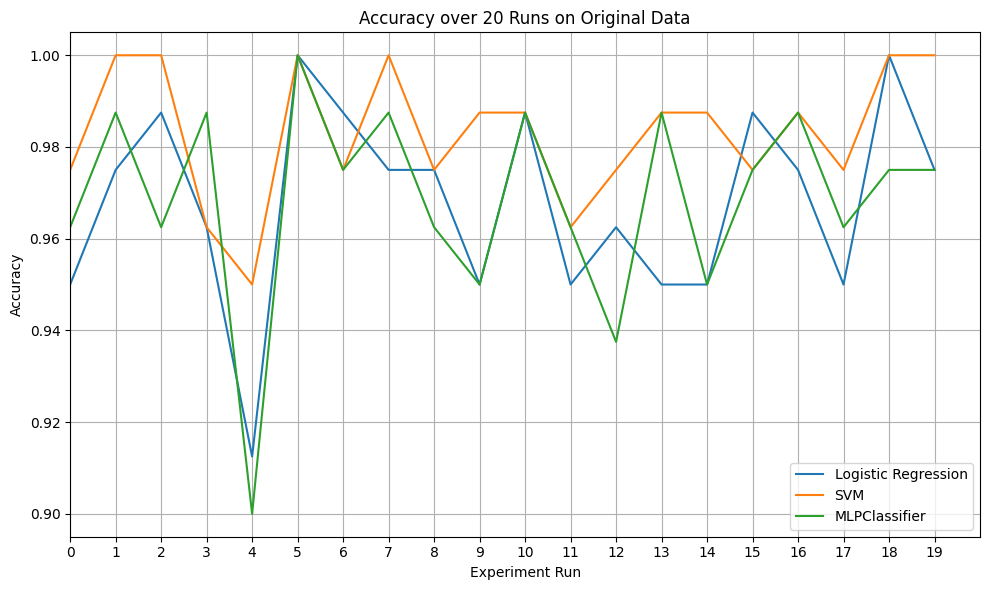

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# 模擬資料前提：已載入 X, y
# 若尚未載入，請先執行你原本的 load_faces() 取得 X, y

# 標準化器（MLPClassifier 使用）
scaler = StandardScaler()

# 模型設定（最佳參數）
logistic_model = LogisticRegression(C=100, solver='lbfgs', multi_class='multinomial', max_iter=1000)
svm_model = SVC(C=0.1, kernel='linear', gamma='scale')
mlp_model = MLPClassifier(hidden_layer_sizes=(64,), activation='tanh', solver='lbfgs',
                          alpha=0.0012196236702823094, learning_rate='constant', max_iter=1000)

# 進行20次訓練測試
n_runs = 20
logistic_acc, svm_acc, mlp_acc = [], [], []

for _ in tqdm(range(n_runs), desc="Running 20 experiments"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    
    # Logistic Regression
    logistic_model.fit(X_train, y_train)
    logistic_acc.append(logistic_model.score(X_test, y_test))
    
    # SVM
    svm_model.fit(X_train, y_train)
    svm_acc.append(svm_model.score(X_test, y_test))
    
    # MLP (使用標準化)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    mlp_model.fit(X_train_scaled, y_train)
    mlp_acc.append(mlp_model.score(X_test_scaled, y_test))

# 畫圖
plt.figure(figsize=(10, 6))
plt.plot(logistic_acc, label='Logistic Regression')
plt.plot(svm_acc, label='SVM')
plt.plot(mlp_acc, label='MLPClassifier')
plt.xlabel('Experiment Run')
plt.ylabel('Accuracy')
plt.xlim(0, n_runs)
plt.xticks(np.arange(0, n_runs, step=1))
plt.title('Accuracy over 20 Runs on Original Data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




### <span style="color:skyblue;">程式碼重點</span>

1. **使用最佳參數模型進行實驗比較**
   分別使用三種模型：

   * `LogisticRegression`：使用先前 Grid Search 得到的最佳參數（C=100 等）
   * `SVC`：使用最佳的 linear 核與 C=0.1
   * `MLPClassifier`：使用最佳的隱藏層與正則化參數，且先進行標準化

2. **重複實驗以觀察穩定性**
   使用 `train_test_split` 搭配 stratify 分層抽樣，執行 20 次，紀錄每次測試準確率，以了解模型對資料切分的敏感程度。

3. **準確率繪圖呈現**
   把三個模型的準確率分別用折線圖畫出來，方便比較模型的整體表現與穩定性差異。

### <span style="color:red;">觀察討論</span>

這張圖顯示了三個模型在原始資料下連續 20 次訓練測試的準確率表現，這裡有幾個重要的觀察點：


橘色的 SVM 線表現最為平穩，準確率幾乎都維持在 97.5%~100% 之間，波動小。這符合先前觀察：SVM 特別適合線性可分、維度高但資料量不大的任務。

綠色的 MLPClassifier 有幾次表現接近或達到 100%，但也有幾次掉到 94% 附近，顯示它的泛化能力不錯，但對於資料切分的敏感度稍高。這可能跟權重初始化或資料標準化細節有關。

Logistic Regression 偶有低落但大致穩定，大部分時間維持在 96~98%，但有幾次掉到 92%，可能是它的分類邊界單一、沒有隱藏層，容易受限於資料分布的變異性。

還有其他的觀察點：

**極端值的影響**
   在第 5 次實驗，三個模型準確率都掉到 0.90~0.92，代表那次的資料切分剛好分布不理想，特別容易暴露模型的弱點，也提醒我們實務上不能只看單次結果。

這個實驗讓我觀察到「模型穩定性」的重要性，不只是找出最高分的模型，而是看哪一種模型在不同切分下都能維持好表現。

### <span style="color:green;">小結</span>

* 若追求**穩定與高準確率**，SVM 是目前最值得優先考慮的模型。
* 若資料未來有機會非線性化或更大、更多樣，MLPClassifier 的彈性會是未來發展空間。
* Logistic Regression 適合當 baseline 或簡單任務，但在這類臉部辨識中，表現略顯保守。



## 2.5 利用指標進行模型評估
接著，我們用第一部分有提到的評估指標來評估這三種模型的性能，並比較它們的優缺點。

分別有準確率 (Accuracy)、精確率 (Precision)、召回率 (Recall) 和 F1-score 這四個指標，這些指標能幫助我們更全面地了解模型的表現。 

這邊我建立了一個DataFrame，來儲存這四個指標的數值，方便我後續跟PCA降維後的模型做比較。



In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

logistic_metrics = []
svm_metrics = []
mlp_metrics = []

for i in tqdm(range(n_runs), desc="Running 20 experiments"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    # Logistic Regression
    logistic_model.fit(X_train, y_train)
    y_pred_lr = logistic_model.predict(X_test)
    logistic_metrics.append({
        "Accuracy": accuracy_score(y_test, y_pred_lr) * 100,
        "Precision": precision_score(y_test, y_pred_lr, average='macro') * 100,
        "Recall": recall_score(y_test, y_pred_lr, average='macro') * 100,
        "F1-score": f1_score(y_test, y_pred_lr, average='macro') * 100
    })

    # SVM
    svm_model.fit(X_train, y_train)
    y_pred_svm = svm_model.predict(X_test)
    svm_metrics.append({
        "Accuracy": accuracy_score(y_test, y_pred_svm) * 100,
        "Precision": precision_score(y_test, y_pred_svm, average='macro') * 100,
        "Recall": recall_score(y_test, y_pred_svm, average='macro') * 100,
        "F1-score": f1_score(y_test, y_pred_svm, average='macro') * 100
    })

    # MLP
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    mlp_model.fit(X_train_scaled, y_train)
    y_pred_mlp = mlp_model.predict(X_test_scaled)
    mlp_metrics.append({
        "Accuracy": accuracy_score(y_test, y_pred_mlp) * 100,
        "Precision": precision_score(y_test, y_pred_mlp, average='macro') * 100,
        "Recall": recall_score(y_test, y_pred_mlp, average='macro') * 100,
        "F1-score": f1_score(y_test, y_pred_mlp, average='macro') * 100
    })

# 建立 DataFrame
df_logistic = pd.DataFrame(logistic_metrics).round(4).add_prefix("Logistic_")
df_svm = pd.DataFrame(svm_metrics).round(4).add_prefix("SVM_")
df_mlp = pd.DataFrame(mlp_metrics).round(4).add_prefix("MLP_")

# 合併成一張總表
df_combined = pd.concat([df_logistic, df_svm, df_mlp], axis=1)
df_combined.loc["Average"] = df_combined.mean()

# 若要匯出 CSV 可加上：
# df_combined.to_csv("model_comparison_metrics.csv", index=False)

# 顯示表格（若你用 Jupyter Notebook）
display(df_combined)


Running 20 experiments:  30%|███       | 6/20 [01:41<04:16, 18.29s/it]c:\Users\SHI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\SHI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Running 20 experiments:  50%|█████     | 10/20 [03:01<03:18, 19.82s/it]c:\Users\SHI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no

,Logistic_Accuracy,Logistic_Precision,Logistic_Recall,Logistic_F1-score,SVM_Accuracy,SVM_Precision,SVM_Recall,SVM_F1-score,MLP_Accuracy,MLP_Precision,MLP_Recall,MLP_F1-score
0,96.250,97.50000,96.250,96.000000,97.50,98.3333,97.50,97.333300,96.250,97.50000,96.250,96.00000
1,96.250,97.50000,96.250,96.000000,98.75,99.1667,98.75,98.666700,97.500,98.33330,97.500,97.33330
2,97.500,98.33330,97.500,97.333300,98.75,99.1667,98.75,98.666700,96.250,97.50000,96.250,96.00000
3,98.750,99.16670,98.750,98.666700,100.00,100.0000,100.00,100.000000,100.000,100.00000,100.000,100.00000
4,98.750,99.16670,98.750,98.666700,100.00,100.0000,100.00,100.000000,95.000,96.25000,95.000,94.75000
5,98.750,99.16670,98.750,98.666700,98.75,99.1667,98.75,98.666700,96.250,97.50000,96.250,96.00000
6,96.250,97.50000,96.250,96.000000,95.00,94.5833,95.00,94.000000,95.000,92.50000,95.000,93.33330
7,100.000,100.00000,100.000,100.000000,100.00,100.0000,100.00,100.000000,98.750,99.16670,98.750,98.66670
8,98.750,99.16670,98.750,98.666700,100.00,100.0000,100.00,100.000000,98.750,99.16670,98.750,98.66670
9,96.250,97.50000,96.250,96.000000,97.50,98.3333,97.50,97.333300,96.250,97.50000,96.250,96.00000


接著將這四個數值利用折線圖呈現出來，讓我能夠更直觀地比較這三種模型的性能差異。

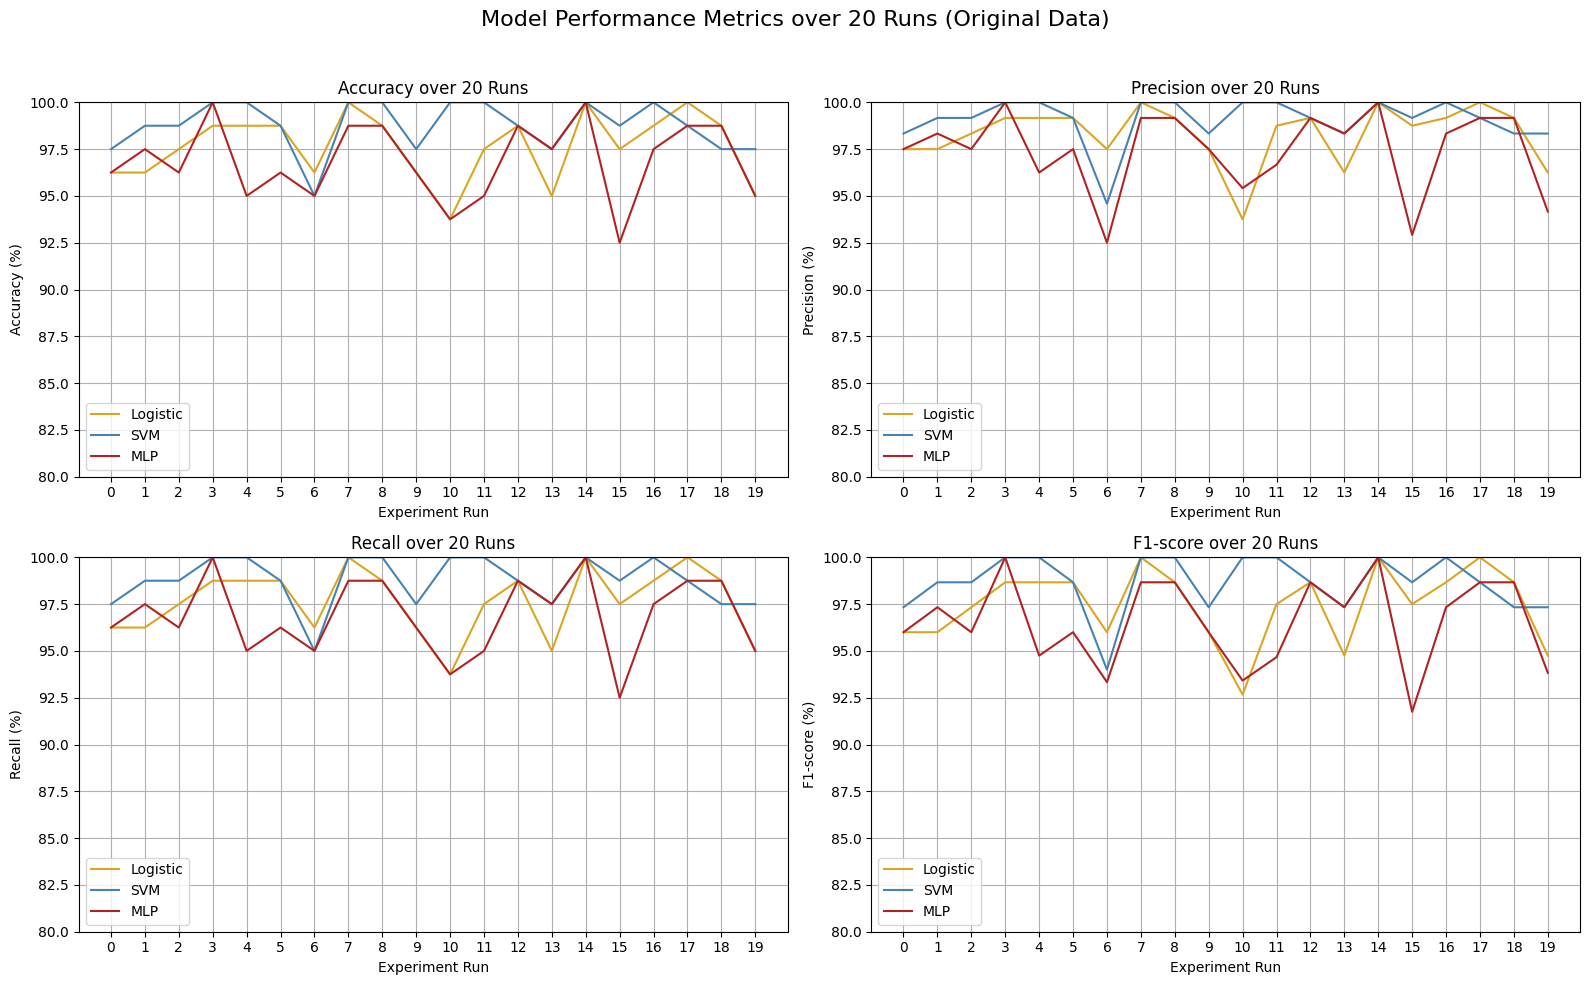

In [9]:
# 繪製 4 張子圖，每個指標一張圖
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
model_prefixes = ['Logistic_', 'SVM_', 'MLP_']
colors = ['goldenrod', 'steelblue', 'firebrick']

plt.figure(figsize=(16, 10))

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    for prefix, color in zip(model_prefixes, colors):
        plt.plot(df_combined[prefix + metric][:-1], label=prefix.rstrip('_'), color=color)
    plt.title(f'{metric} over 20 Runs')
    plt.xlabel('Experiment Run')
    plt.ylabel(f'{metric} (%)')
    plt.ylim(80, 100)
    plt.xticks(np.arange(0, n_runs, step=1))
    plt.grid(True)
    plt.legend()

plt.suptitle('Model Performance Metrics over 20 Runs (Original Data)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### <span style="color:skyblue;">程式碼重點</span>

1. **四項分類指標完整計算**
   每輪實驗針對三種模型分別計算：

   * Accuracy（準確率）：整體正確分類比例
   * Precision（精確率）：每類被預測為正的樣本中，有多少是對的
   * Recall（召回率）：每類實際為正的樣本中，有多少被預測出來
   * F1-score：Precision 與 Recall 的加權平均

2. **平均採用 `macro` 策略**
   所有分數都是用 `average='macro'` 計算，代表每一類別的分數一視同仁，避免某幾類過多樣本影響總分。

3. **將結果組成表格並繪圖**
   建立 DataFrame 合併三種模型的每次分數與平均，最後分別畫出四張子圖。


### <span style="color:red;">觀察討論</span>

#### 1. **SVM 全面領先，且穩定性極高**

* 無論是準確率、精確率、召回率還是 F1-score，藍色的 SVM 幾乎都維持在 98%~100% 區間。
* 各次實驗幾乎沒有大幅下滑，顯示模型非常穩定。

#### 2. **Logistic Regression 表現相對穩健，略遜於 SVM**

* 黃色線條整體落在 96~99% 之間，在大多數指標都與 SVM 接近。
* 在 Recall 與 F1-score 偶爾略低，但整體穩定，波動範圍不大。

#### 3. **MLPClassifier 表現波動較大，但也沒有到特別差**

* 紅色線條雖偶爾也能達到接近 100%，但在個別 run 中偶爾掉到 92% 附近，特別是 Recall 和 F1-score。

可能模型對於資料切分與初始權重較敏感，可能導致 underfitting 或收斂失敗，需要較多超參數微調或增強正則化來提升穩定性。





## 2.6 以`PCA降維資料`進行模型訓練與評比

接下來我想測試 PCA 降維後的版本，也可以用同樣流程再畫一次圖，觀察指標是否有更穩定或更準。

### 2.6.1 尋找 適合的 PCA 主成分數量
在進行 PCA 降維之前，我們需要先決定要保留多少主成分，這裡我使用了 `explained_variance_ratio_` 來幫助我決定要保留多少主成分。

這個指標告訴我每個主成分對總變異的貢獻程度，透過繪製累積貢獻率圖，我可以直觀地看到要保留多少主成分才能達到 80% 的變異解釋率。

達到 80% 累積解釋變異量所需的主成分數量: 44
達到 90% 累積解釋變異量所需的主成分數量: 111
達到 95% 累積解釋變異量所需的主成分數量: 190


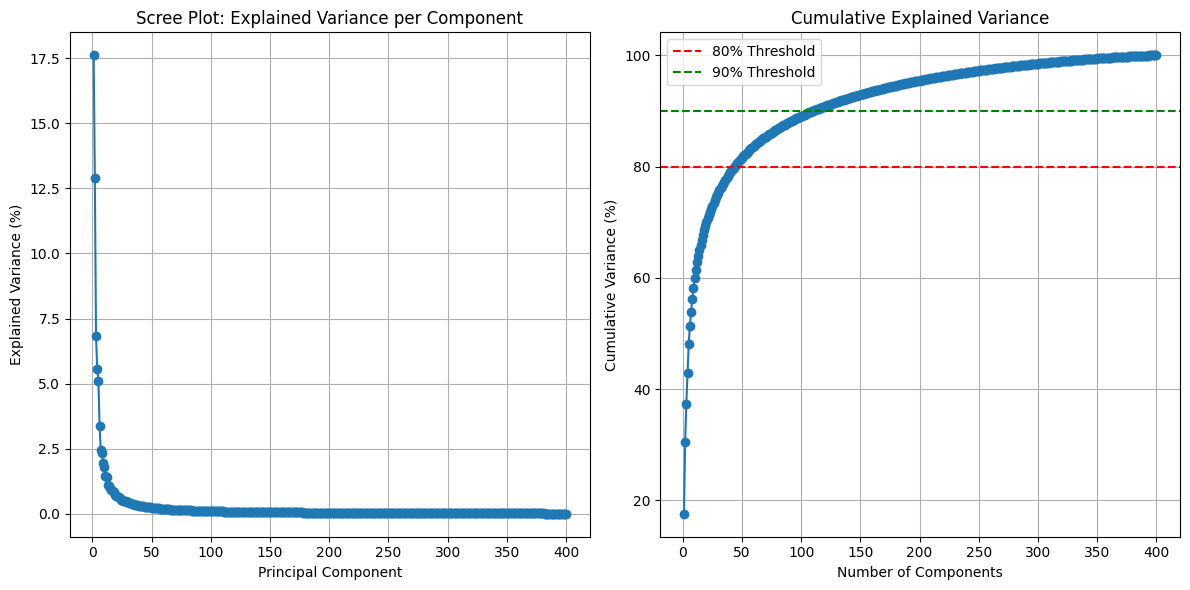

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# 執行 PCA（保留所有主成分以利分析）
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X)

explained_var = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)


# 找出達到 80%、90%、95% 累積解釋變異量所需的主成分數量
components_80 = np.argmax(cumulative_var >= 0.80) + 1
components_90 = np.argmax(cumulative_var >= 0.90) + 1
components_95 = np.argmax(cumulative_var >= 0.95) + 1

{
    "components_for_80%": components_80,
    "components_for_90%": components_90,
    "components_for_95%": components_95
}

print("達到 80% 累積解釋變異量所需的主成分數量:", components_80)
print("達到 90% 累積解釋變異量所需的主成分數量:", components_90)
print("達到 95% 累積解釋變異量所需的主成分數量:", components_95)

# 畫圖：Scree plot 與 Cumulative explained variance
plt.figure(figsize=(12, 6))

# Scree Plot
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(explained_var) + 1), explained_var * 100, marker='o')
plt.title("Scree Plot: Explained Variance per Component")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance (%)")
plt.grid(True)

# Cumulative Variance Plot
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(cumulative_var) + 1), cumulative_var * 100, marker='o')
plt.axhline(y=80, color='r', linestyle='--', label="80% Threshold")
plt.axhline(y=90, color='g', linestyle='--', label="90% Threshold")
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



### <span style="color:skyblue;">程式碼重點</span>

1. **完整 PCA 分解與主成分分析**

   * 使用 `PCA()` 保留所有主成分（不事先指定 `n_components`），方便進一步分析每個主成分的解釋變異量。
   * `explained_variance_ratio_` 回傳每個主成分所貢獻的變異比例。

2. **計算累積解釋變異量**

   * 用 `np.cumsum` 累加所有主成分的解釋變異量，得出第 k 個主成分為止的總解釋比例。
   * 接著用 `np.argmax(...) + 1` 找出滿足 80%、90%、95% 解釋量門檻所需的最小主成分數量。

3. **繪製兩張分析圖**

   * **Scree Plot**（左圖）：顯示每個主成分單獨貢獻多少變異量。通常能觀察出「肘部」在哪（例如前 10\~20 個主成分下降最快）。
   * **Cumulative Variance Plot**（右圖）：觀察累積解釋比例的變化，並用虛線標示出常見門檻（80%、90%）。

### <span style="color:red;">觀察討論</span>

1. **前 44 個主成分已保留 80% 資訊**

   * 原始影像資料有 10304 維，而僅使用前 **44 維就能保留 80% 的變異量**，降維效果非常顯著。
   * 若用於視覺化或模型快速預訓練，這是一個很好的主成分數量選擇。

2. **保留 90%、95% 時需較多主成分**

   * **90%：111 個主成分**
   * **95%：190 個主成分**
雖然提升了解釋力，但維度也迅速上升，可能會拖慢訓練速度或導致 overfitting（尤其在樣本數只有 400 張時）。

3. **Scree Plot 顯示前 10\~20 個主成分貢獻最大**

   從圖中可看出變異量的下降速度非常快，這也說明影像資料在特定方向上有強烈的資訊聚集（例如臉部輪廓、光影差異）。


### 2.6.2 使用 80% 變異解釋率的 PCA 降維資料進行模型訓練
這次比較的是 使用 PCA 降到 44 維後（保留 80% 資訊）三種模型在 20 次實驗中的表現

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
from tqdm import tqdm

# 重新計算 80% 變異量的 PCA（指定 n_components=44）
pca = PCA(n_components=44)
X_pca = pca.fit_transform(X)

# 模型設定（與原始版本一致）
logistic_model = LogisticRegression(C=100, solver='lbfgs', multi_class='multinomial', max_iter=1000)
svm_model = SVC(C=0.1, kernel='linear', gamma='scale')
mlp_model = MLPClassifier(hidden_layer_sizes=(64,), activation='tanh', solver='lbfgs',
                          alpha=0.0012196236702823094, learning_rate='constant', max_iter=1000)

# 評估指標記錄
logistic_metrics_pca = []
svm_metrics_pca = []
mlp_metrics_pca = []

for _ in tqdm(range(20), desc="Running 20 PCA experiments"):
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, stratify=y)

    # Logistic Regression
    logistic_model.fit(X_train, y_train)
    y_pred_lr = logistic_model.predict(X_test)
    logistic_metrics_pca.append({
        "Accuracy": accuracy_score(y_test, y_pred_lr) * 100,
        "Precision": precision_score(y_test, y_pred_lr, average='macro') * 100,
        "Recall": recall_score(y_test, y_pred_lr, average='macro') * 100,
        "F1-score": f1_score(y_test, y_pred_lr, average='macro') * 100
    })

    # SVM
    svm_model.fit(X_train, y_train)
    y_pred_svm = svm_model.predict(X_test)
    svm_metrics_pca.append({
        "Accuracy": accuracy_score(y_test, y_pred_svm) * 100,
        "Precision": precision_score(y_test, y_pred_svm, average='macro') * 100,
        "Recall": recall_score(y_test, y_pred_svm, average='macro') * 100,
        "F1-score": f1_score(y_test, y_pred_svm, average='macro') * 100
    })

    # MLP with standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    mlp_model.fit(X_train_scaled, y_train)
    y_pred_mlp = mlp_model.predict(X_test_scaled)
    mlp_metrics_pca.append({
        "Accuracy": accuracy_score(y_test, y_pred_mlp) * 100,
        "Precision": precision_score(y_test, y_pred_mlp, average='macro') * 100,
        "Recall": recall_score(y_test, y_pred_mlp, average='macro') * 100,
        "F1-score": f1_score(y_test, y_pred_mlp, average='macro') * 100
    })

# 建立 DataFrame
df_logistic_pca = pd.DataFrame(logistic_metrics_pca).round(4).add_prefix("Logistic_")
df_svm_pca = pd.DataFrame(svm_metrics_pca).round(4).add_prefix("SVM_")
df_mlp_pca = pd.DataFrame(mlp_metrics_pca).round(4).add_prefix("MLP_")

# 合併成一張總表
df_combined_pca = pd.concat([df_logistic_pca, df_svm_pca, df_mlp_pca], axis=1)
df_combined_pca.loc["Average"] = df_combined_pca.mean()

df_combined_pca


Running 20 PCA experiments: 100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


### 2.6.3 PCA 降維後的模型評比
同樣使用四項指標：Accuracy、Precision、Recall、F1-score，針對 PCA 降維後的資料進行模型評比，並將結果繪製成折線圖，方便比較三種模型的性能差異。

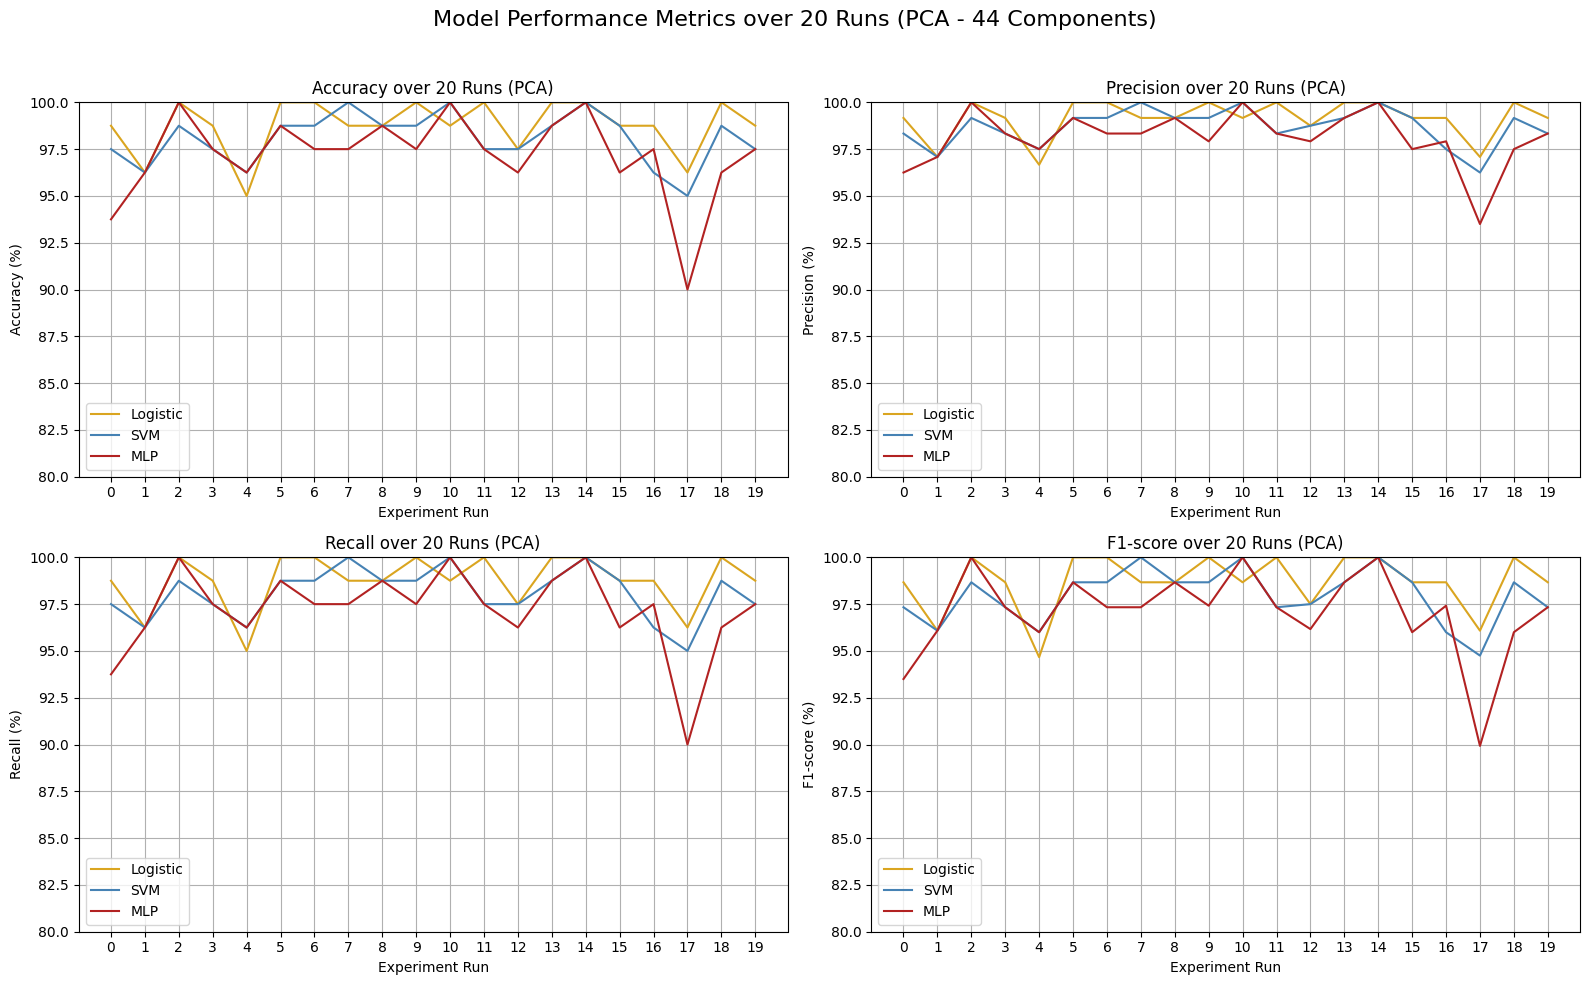

In [16]:
# 繪製 4 張子圖，每個指標一張圖（for PCA）
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
model_prefixes = ['Logistic_', 'SVM_', 'MLP_']
colors = ['goldenrod', 'steelblue', 'firebrick']

plt.figure(figsize=(16, 10))

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    for prefix, color in zip(model_prefixes, colors):
        plt.plot(df_combined_pca[prefix + metric][:-1], label=prefix.rstrip('_'), color=color)
    plt.title(f'{metric} over 20 Runs (PCA)')
    plt.xlabel('Experiment Run')
    plt.ylabel(f'{metric} (%)')
    plt.ylim(80, 100)
    plt.xticks(np.arange(0, n_runs, step=1))
    plt.grid(True)
    plt.legend()

plt.suptitle('Model Performance Metrics over 20 Runs (PCA - 44 Components)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


了解！以下是你這段 PCA（保留 44 個主成分）實驗流程與圖表分析的統一格式整理：

---

### <span style="color:skyblue;">程式碼重點</span>

基本與使用原始資料的流程與程式碼相似，但這次我們使用 PCA 降維後的資料進行模型訓練與評比

1. **PCA 降維（保留 80% 解釋變異量）**
   使用 `PCA(n_components=44)` 將 10304 維的臉部影像資料降到 44 維，保留約 80% 的資訊。這樣可以大幅減少特徵數，提高運算效率。

2. **三種分類器模型設定與使用**

   * Logistic Regression 使用之前最佳參數（C=100，multinomial）
   * SVM 採用 `linear` 核與 C=0.1
   * MLPClassifier 使用隱藏層大小為 64、激活函數為 tanh、lbfgs 優化器，並搭配 `StandardScaler` 做特徵標準化

3. **進行 20 次實驗並評估四大分類指標**
   每輪訓練/測試切分後分別計算 Accuracy、Precision、Recall 與 F1-score（macro 平均），再將每個模型的結果分別紀錄到 DataFrame 中。

4. **繪製四個子圖觀察變化趨勢**
   最後畫出每個指標在 20 次實驗中的走勢圖，觀察模型表現的穩定性與波動情形。


### <span style="color:red;">觀察討論</span>

1. **Logistic Regression 表現依然穩健**

   * 幾乎在所有指標上都接近或高於 98%，且波動小。，在 PCA 降維後依然維持高度穩定性，顯示 Logistic Regression 能很好地處理低維的線性空間。

2. **SVM 維持高準確率，但略有波動**

   * 準確率與 F1-score 大多落在 96\~100%，仍是優秀表現，但與未降維版本相比，這次在某些 run 中略微下降（可能是部分邊界訊息在 PCA 中被壓縮掉），波動性略升。

3. **MLPClassifier 整體表現略降，波動更加明顯**

   * 有些 run 準確率掉到 90% 附近，甚至 Precision 一度低於 93%。
   * 儘管大部分 run 表現仍穩定在 96\~98%，但受 PCA 壓縮資訊的影響較明顯。

   可能 MLP 這類非線性模型可能更仰賴高維原始特徵來擷取非線性資訊，不太確定這邊是否是 PCA 壓縮後的資訊損失導致的。

## 2.7 原始資料與 PCA 降維資料的模型比較
最後，我們將原始資料與 PCA 降維後的資料進行模型比較，這裡我們會使用三種分類器：Multinomial Logistic Regression、SVM 和 Neural Network，並繪製長條圖比較它們的性能。 

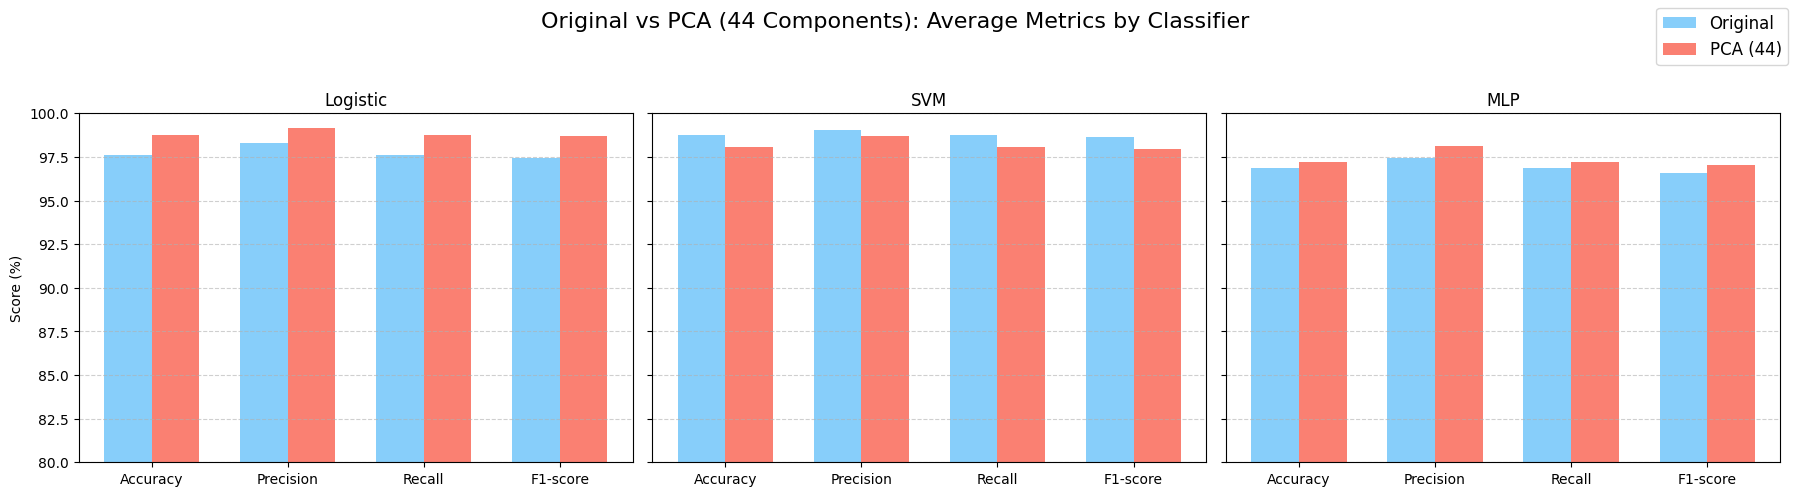

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# 從兩個 df 抓出平均
avg_ori = df_combined.loc["Average"]
avg_pca = df_combined_pca.loc["Average"]

models = ['Logistic', 'SVM', 'MLP']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
bar_width = 0.35
x = np.arange(len(metrics))

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, model in enumerate(models):
    ori_vals = [avg_ori[f"{model}_{metric}"] for metric in metrics]
    pca_vals = [avg_pca[f"{model}_{metric}"] for metric in metrics]

    ax = axes[i]
    ax.bar(x - bar_width/2, ori_vals, bar_width, label='Original', color='lightskyblue')
    ax.bar(x + bar_width/2, pca_vals, bar_width, label='PCA (44)', color='salmon')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.set_ylim(80, 100)
    ax.set_title(f"{model}")
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)
    if i == 0:
        ax.set_ylabel("Score (%)")

# 圖外 legend（右上角）
fig.legend(['Original', 'PCA (44)'], loc='upper right', fontsize=12)
fig.suptitle("Original vs PCA (44 Components): Average Metrics by Classifier", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()



### <span style="color:skyblue;">程式碼重點</span>

1. **抓取每個模型的平均分數資料**

   * 使用 `df_combined.loc["Average"]` 和 `df_combined_pca.loc["Average"]` 分別取得三個模型在原始資料與 PCA（44 components）上的平均 Accuracy、Precision、Recall 和 F1-score。
   * 指標名稱用統一格式 `{模型名稱}_{指標}` 抽取欄位值（如 `SVM_F1-score`）。

2. **繪製分組長條圖以利視覺比較**

   * 每個子圖代表一種模型（Logistic、SVM、MLP），X 軸為四個指標，Y 軸為百分比分數。
   * 使用 `bar_width = 0.35` 設定兩組條狀圖間距，左邊為原始資料（藍色）、右邊為 PCA 資料（紅色）。
   * 共享 Y 軸尺度 (`sharey=True`)，方便比較跨模型的高低落差。
   * 加上 `grid=True` 提供輔助線，並統一標高為 80\~100% 以凸顯模型間細微差異。

3. **統一圖例與整體標題**

   * `fig.legend()` 設定外部圖例並指定顏色對應。
   * `plt.tight_layout(rect=[0, 0, 1, 0.92])` 預留空間顯示總標題。

### <span style="color:red;">觀察討論</span>

1. **Logistic Regression 表現全面提升**

   * 在所有指標（Accuracy、Precision、Recall、F1-score）中，PCA 壓縮後反而表現**略高於原始資料**。
   * 顯示 Logistic Regression 對高維資料容易受雜訊干擾，PCA 的降維有助於模型專注在主要資訊上。

2. **SVM 準確率與泛化略受影響**

   * SVM 在原始資料下表現稍好，尤其在 Accuracy 與 Recall 上，PCA 版本略微下降。
   * 表示 SVM 能善用高維特徵的線性邊界特性，而 PCA 降維可能捨棄部分區別力。

3. **MLP 在 PCA 版本稍有改善**

   * MLP 原本在 Recall 與 F1-score 的平均分數略低，而在 PCA 版本中這兩項指標**略有提升**。
   * 表示在維度壓縮後，神經網路更容易收斂、不會受雜訊與高維干擾影響；同時也可能是標準化效果更顯著發揮作用。

雖然這張圖只展示模型表現，但實際在執行中，PCA 降到 44 維也帶來**訓練速度加快**、**過擬合風險下降**的好處，特別是在樣本數有限（400 張）且特徵維度極高（10304）的資料集上，PCA 算是非常實用的前處理方法。



# 3. 結論

## 3.1 使用方法與流程

1. **資料來源與前處理**
   使用 AT\&T Face Dataset（共 400 張灰階圖像，40 人 × 每人 10 張），將每張 64×64 圖像展平成一維向量。

2. **模型建立與參數調校**
   採用三種模型進行比較：

   * Logistic Regression（多類別、正則化調整）
   * SVM（線性核）
   * MLPClassifier（單層神經網路，搭配標準化）

   透過 Grid Search 或 Random Search 找出最佳參數設定。

3. **PCA 降維分析**
   執行 PCA 分析主成分對資料變異的解釋能力，並選定 44 個主成分作為保留 80% 資訊的壓縮版本，作為與原始資料的比較基準。

4. **重複實驗與評估指標**
   每個模型分別在原始資料與 PCA 壓縮資料上重複 20 次 train/test split 實驗，評估四項分類指標：

   * Accuracy
   * Precision
   * Recall
   * F1-score（皆採用 macro 平均）

5. **視覺化與比較**
   透過折線圖與分組長條圖觀察每次實驗結果與平均表現，評估模型穩定性與表現趨勢。


## 3.2 主要發現與結論

1. **Logistic Regression 搭配 PCA 表現最佳**
   在降至 44 維後，Logistic Regression 四項指標全面提升且波動極小，顯示其能有效利用主要特徵資訊，並降低維度雜訊影響。

2. **SVM 表現在原始資料下最穩定**
   SVM 在原始高維資料上的表現最為穩定，20 次實驗中準確率幾乎都維持在 98% 以上，降維後略有下降但仍具競爭力。

3. **MLPClassifier 波動較大，降維後略穩定**
   MLPClassifier 在原始資料上表現不穩，偶有高分也有明顯下滑，在經過 PCA 降維後整體表現略為改善，但仍不如前兩者穩定。

4. **PCA 降維有效提升效率與穩定性**
   在特徵維度為 10304 而樣本數僅 400 的情境下，PCA 降至 44 維已能保留 80% 資訊，顯著降低計算成本並提升 Logistic 與 MLP 的收斂表現。


在高維且樣本數有限的臉部分類任務中，PCA 搭配 Logistic Regression 可達成穩定、準確且高效的分類效果。SVM 在高維原始特徵下則具備極佳的精準度與一致性，而 MLPClassifier 需搭配適當降維與正則化以維持穩定表現。




